In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
meta = pd.read_csv('./datasets/movie-subtitles/movies_meta.csv')

In [97]:
import json
def json_to_series(text):
    keys, values = zip(*[(item[1], 1) for dct in json.loads(text) for item in dct.items() if item[0] == "name"])
    return pd.Series(list(values), index=keys)

In [111]:
text = '[{"id": 16, "name": "Animation"}, {"id": 35, "name": "Comedy"}, {"id": 10751, "name": "Family"}]'
keys, values = zip(*[(item[1], 1) for dct in json.loads(text) for item in dct.items() if item[0] == "name"])
pd.Series(list(values), index=keys)

Animation    1
Comedy       1
Family       1
dtype: int64

In [117]:
def genre_lst(text: str):
    return [dct['name'] for dct in json.loads(text.replace("'", '"'))]

genre_lst("[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]")

['Animation', 'Comedy', 'Family']

In [119]:
meta['genre_lst'] = meta.apply(lambda row : genre_lst(row.genres), axis=1)

In [122]:
meta[['imdb_id', 'genre_lst', 'title']].head(20)

,imdb_id,genre_lst,title
0,tt0114709,"[Animation, Comedy, Family]",Toy Story
1,tt0113497,"[Adventure, Fantasy, Family]",Jumanji
2,tt0113189,"[Adventure, Action, Thriller]",GoldenEye
3,tt0113627,"[Drama, Romance]",Leaving Las Vegas
4,tt0114746,"[Science Fiction, Thriller, Mystery]",Twelve Monkeys
5,tt0112637,"[History, Drama, Romance]",Carrington
6,tt0112818,[Drama],Dead Man Walking
7,tt0113442,"[Comedy, Family, Romance]",It Takes Two
8,tt0112697,"[Comedy, Drama, Romance]",Clueless
9,tt0113855,"[Action, Fantasy]",Mortal Kombat


In [3]:
subtitles = pd.read_csv('./datasets/movie-subtitles/movies_subtitles.csv')

In [131]:
subtitles = subtitles.drop_duplicates()

In [11]:
subtitles.head(10)


,start_time,end_time,text,imdb_id
0,58.559,61.602,"BOY: All right, everyone!\nThis... is a stick-up!",tt0114709
1,61.687,63.354,Don't anybody move!,tt0114709
2,64.398,66.482,"Now, empty that safe!",tt0114709
3,68.318,71.612,"Ooh-hoo-hoo!\nMoney, money, money! (KISSING)",tt0114709
4,71.697,74.031,"Stop it! Stop it,\nyou mean, old potato!",tt0114709
5,74.116,77.160,"Quiet, Bo Peep,\nor your sheep get run over!",tt0114709
6,77.327,79.328,Help! Baa!\nHelp us!,tt0114709
7,79.413,82.957,"Oh, no, not my sheep!\nSomebody do something!",tt0114709
8,89.339,92.425,VOICE BOX: Reach for the sky!,tt0114709
9,92.509,94.677,"Oh, no! Sheriff Woody!",tt0114709


In [31]:
def preprocess_subtitle(text: str):
  new_text = []
  for t in text.split():
    if t.upper() == t:
      continue
    new_text.append(t)
  return " ".join(new_text)

In [132]:
subtitles.loc[subtitles['imdb_id'] == 'tt0113497'].duplicated()

1386    False
1387    False
1388    False
1389    False
1390    False
        ...  
3154    False
3155    False
3156    False
3157    False
3158    False
Length: 1773, dtype: bool

In [149]:
def is_same_scene(prev, curr, min_time_gap, max_scene_length):
    if curr.imdb_id != prev['imdb_id']:
        return False
    
    if len(prev['text']) + len(curr.text) > max_scene_length:
        return False
    
    time_diff = curr.start_time - prev['end_time']
    
    if time_diff > min_time_gap:
        return False
    
    return True

def extract_scenes_1(subtitles: pd.DataFrame, min_time_gap = 30, max_scene_length = 1200):
    current_scene = None
    # {
    #     'start': None,
    #     'end': None,
    #     'text': None
    # }
    for i in tqdm(range(subtitles.shape[0])):
        row = subtitles.iloc[i]
        if any(row.isna()):
            continue
        if not current_scene:
            current_scene = {
                'start_time': row.start_time,
                'end_time': row.end_time,
                'text': row.text,
                'imdb_id': row.imdb_id
            }
            continue
        # same scene
        if not is_same_scene(current_scene, row, min_time_gap, max_scene_length):
            yield current_scene
            current_scene = {
                'start_time': row.start_time,
                'end_time': row.end_time,
                'text': row.text,
                'imdb_id': row.imdb_id
            }
        else:
            current_scene['end_time'] = row.end_time
            current_scene['text'] = ' '.join([current_scene['text'], row.text])
    yield current_scene

In [246]:
def extract_scenes_2(subtitles: pd.DataFrame, min_count=100, max_length=1400):
    for imdb_id, group in subtitles.groupby('imdb_id'):
        time_gaps = pd.DataFrame(np.nan, index=range(0, len(group)), columns=['time_gap'])
        for i in tqdm(range(1, len(group))):
            time_gaps.iloc[i].time_gap = group.iloc[i].start_time - group.iloc[i - 1].end_time
        sorted = time_gaps.sort_values('time_gap', ascending=False)
        largest = sorted.nlargest(min_count, ['time_gap'])
        # print(largest.index)
        def get_scene_id(i):
            return largest[largest.index > i].index.min()

        print(group.groupby(lambda s : print(s['imdb_id']), axis=1))
        # print(get_scene_id(0))

extract_scenes_2(subtitles.loc[subtitles['imdb_id'] == 'tt0113419'])


  0%|          | 0/692 [00:00<?, ?it/s]

TypeError: string indices must be integers

In [238]:
extract_scenes_2(subtitles.loc[subtitles['imdb_id'] == 'tt0113419'])

  0%|          | 0/692 [00:00<?, ?it/s]

None


In [156]:
scenes2 = pd.DataFrame(extract_scenes_1(subtitles.loc[subtitles['imdb_id'] == 'tt0113419']))

  0%|          | 0/693 [00:00<?, ?it/s]

In [157]:
scenes2.shape

(38, 4)

In [158]:
scenes2.head()

,start_time,end_time,text,imdb_id
0,158.360,318.151,"We'II pick up your drawing. Hi, Mom. - Bye, Ri...",tt0113419
1,325.000,401.798,- It works!\n- Let me see. My grandmother gave...,tt0113419
2,612.600,716.115,You hurt me. - HeIIo.\n- Demon! - Demon?\n- Gi...,tt0113419
3,760.120,802.596,I think your meaIy worms are dead. They're in ...,tt0113419
4,860.639,953.990,I won't hurt you. - This is magic?\n- I guess....,tt0113419


In [152]:
maxlen = scenes.text.str.len().max()
long_scene = preprocess_subtitle(scenes[scenes['text'].str.len() == maxlen].iloc[0].text)

In [153]:
long_scene

'In order to finish, you gotta complete all the levels. Levels are gonna get harder as we go along. We complete the levels... Do you even know where we\'re going? Kind of. Kind of? Oh, that\'s good, then. We\'re in good hands. Okay, the missing piece, I\'m guessing. That must be what we\'re looking for, the missing piece of the map. The problem is, there\'s nothing here. What do you mean? It\'s a map, just like he said. It\'s a map of Jumanji. Cartography. What\'s that? The study of maps. It was one of Professor Oberon\'s skills. Yes. That\'s right. Oh, so you can\'t see this, but can? The characters we chose, we all have certain skills. So there\'s gotta be a way to access our... Oh! Wow. What\'d you just do? "Strengths: Fearless. Climbing. Speed. Boomerang. Smoldering intensity." What the hell are you doing? What just happened? Um, you just smoldered. "Weakness. None"? How\'d you do that? That, uh, list? Well, just... think just pressed my enormous left pec. It\'s like the boob area.

In [34]:
from transformers import pipeline
# classifier = pipeline("text-classification",
#                       model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
classifier = pipeline("text-classification",
                      model="bhadresh-savani/distilbert-base-uncased-emotion", return_all_scores=True)

C:\Users\eitam\AppData\Roaming\Python\Python39\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [80]:
classifier(long_scene)


[[{'label': 'sadness', 'score': 0.127582848072052},
  {'label': 'joy', 'score': 0.2385679930448532},
  {'label': 'love', 'score': 0.0031797634437680244},
  {'label': 'anger', 'score': 0.6008118987083435},
  {'label': 'fear', 'score': 0.026537543162703514},
  {'label': 'surprise', 'score': 0.003319951007142663}]]

In [179]:
def get_emotion_feats(classifier_res: list[list[dict]]):
  return { x['label']: x['score'] for x in classifier_res[0] }

def get_scene_emotions(df):
    for i in tqdm(range(df.shape[0])):
        scene = df.iloc[i]
        try:
          txt = preprocess_subtitle(scene.text)
          feats = get_emotion_feats(classifier(txt))
          feats['imdb_id'] = scene.imdb_id
          feats['text'] = txt
        except:
          print('error, length: ', len(scene.text))
        yield feats

In [182]:
def get_movie_emots(imdb_id, min_time_gap=10, max_scene_length=1000):
    scenes = pd.DataFrame(extract_scenes_1(
        subtitles.loc[subtitles['imdb_id'] == imdb_id], min_time_gap, max_scene_length))
    return pd.DataFrame(get_scene_emotions(scenes))


Toy Story ['Animation', 'Comedy', 'Family']


  0%|          | 0/1386 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

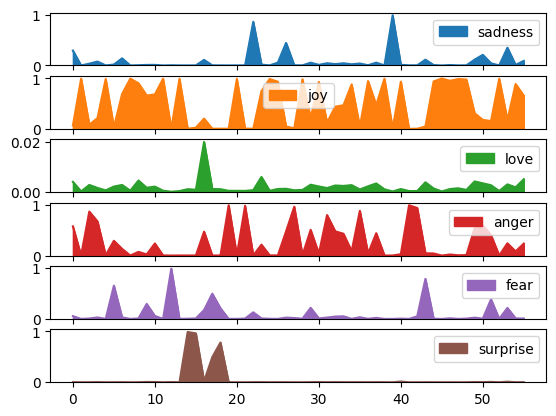

Jumanji ['Adventure', 'Fantasy', 'Family']


  0%|          | 0/1773 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

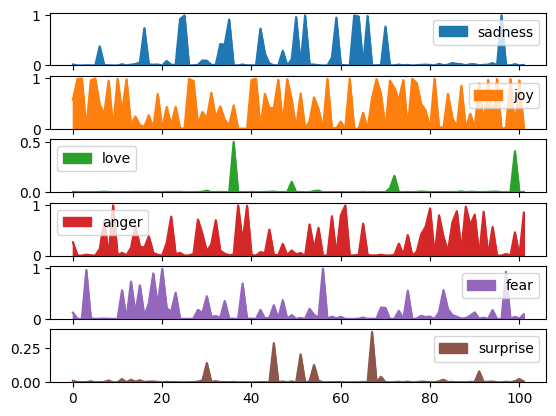

GoldenEye ['Adventure', 'Action', 'Thriller']


  0%|          | 0/901 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

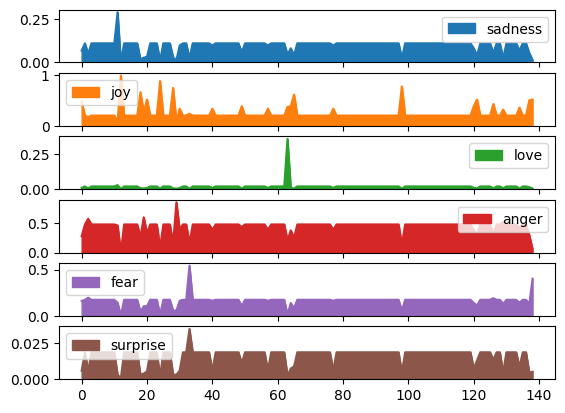

Leaving Las Vegas ['Drama', 'Romance']


  0%|          | 0/865 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

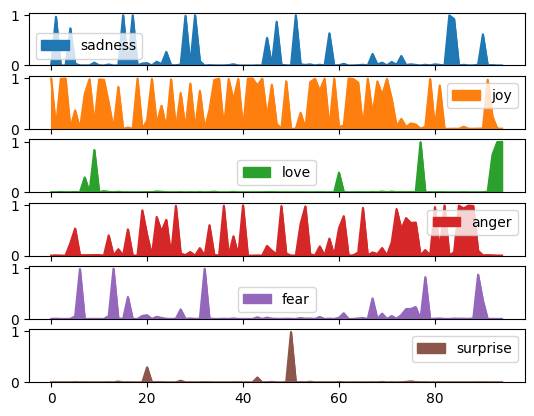

Twelve Monkeys ['Science Fiction', 'Thriller', 'Mystery']


  0%|          | 0/1625 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

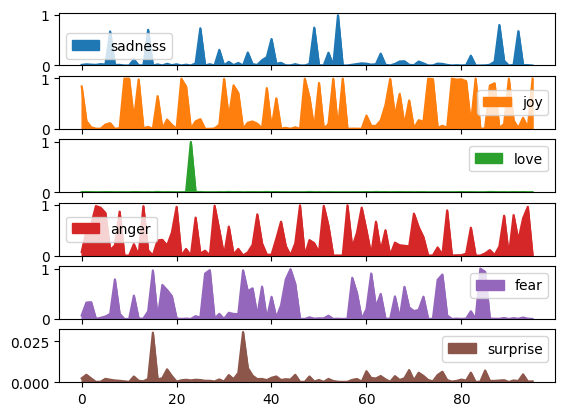

In [188]:
for i, movie in meta.head().iterrows():
    print(movie.title, movie.genre_lst)
    emots = get_movie_emots(movie.imdb_id)
    emots.plot.area(subplots=True)
    plt.show()